In [1]:
import argparse
import csv
import os
import tqdm
import pdb
import shutil
import time
import torch
import numpy as np
import torchvision
import torch.nn as nn
import os.path as osp
import torch.optim as optim
from torchvision import datasets, models
from functools import partial
import torchvision.models as models
import torch.optim as optim
from torch.autograd import Variable
from torch.backends import cudnn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import DataPreProccessing_1GA
from model.baseline import Pre_ResNet18Model1

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import matplotlib.pyplot as plt

C:\Users\HIREE\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\HIREE\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
model=Pre_ResNet18Model1(num_classes=5)
#model=my_InceptionV3(num_classes=5)
#model=resnet18_ccsam(num_classes=5)
#model=ccsam_inception_v3(num_classes=5)
#model = Freezing_layer_Resnet18WithCCSAM1(num_classes=num_classes, pretrained=True)
#model = model.cuda()

print(model)

Pre_ResNet18Model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [3]:
# get the number of model parameters
print('Total Number of model parameters: {}'.format(
    sum([p.data.nelement() for p in model.parameters()])))
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
num_non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)

print("Number of trainable parameters:", num_trainable_params)
print("Number of non-trainable parameters:", num_non_trainable_params)


Total Number of model parameters: 11309637
Number of trainable parameters: 133125
Number of non-trainable parameters: 11176512


In [4]:
!python DataPreProccessing_1GA.py

In [5]:
# Data loading

train_loader,valid_loader, TestLoader = DataPreProccessing_1GA.preproccessing()
# Define the class labels
class_labels = ['FMD', 'KCD', 'LD', 'RWD', 'WD']


Total Number of training and validation images processing per batches: 7854
Total Number of training images processing per batches: 982 267
Total Number of images in Testing folder: 2130


In [16]:
#For this example, we'll be using a cross-entropy loss. For demonstration purposes, we'll create batches of dummy output and label values, run them through the loss function, and examine the result.
criterion = nn.CrossEntropyLoss().cuda()
# NB: Loss functions expect data in batches, so we're creating batches of 5
# Represents the model's confidence in each of the 5 classes for a given input
dummy_outputs = torch.rand(4, 5)
# Represents the correct class among the 5 being tested
class_labels = torch.tensor([1, 2, 3,4])
    
print(dummy_outputs)
print(class_labels)

loss = criterion(dummy_outputs, class_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.0816, 0.7364, 0.5701, 0.6013, 0.9144],
        [0.3087, 0.2494, 0.4809, 0.3605, 0.9759],
        [0.4387, 0.0420, 0.6295, 0.9257, 0.7012],
        [0.7401, 0.5881, 0.3205, 0.8118, 0.5745]])
tensor([1, 2, 3, 4])
Total loss for this batch: 1.51481032371521


In [6]:
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-4)

In [7]:
# Set up tensorboard writer
# Initializing in a separate cell so we can easily add more epochs to the same run
filename = 'Pre_ResNet18Model1'
#filename = 'my_InceptionV3'
#filename = 'resnet18_ccsam'
#filename = 'ccsam_inception_v3'
#filename = 'Freezing_layer_Resnet18WithCCSAM1'
log_dir = 'E:/jupyter notebook/my_trying_fie/All_In_One/by_my_code/Results_log/logsOf_first_GA/'
#log_dir = 'E:/jupyter notebook/my_trying_fie/All_In_One/by_my_code/Results_log/logsOf_first_GA/'
#log_dir = 'E:/jupyter notebook/my_trying_fie/All_In_One/by_my_code/Results_log/logsOf_first_GA/'
#log_dir = 'E:/jupyter notebook/my_trying_fie/All_In_One/by_my_code/Results_log/logsOf_first_GA/'
#log_dir = 'E:/jupyter notebook/my_trying_fie/All_In_One/by_my_code/Results_log/logsOf_first_GA/'
Saved_model_path="E:/jupyter notebook/my_trying_fie/All_In_One/by_my_code/saved_model_code/"
writer = SummaryWriter(log_dir + filename)



Epoch 1: Training Loss: 0.159 -- Training Accuracy: 66.072%  -- Validation Loss: 0.652  -- Validation Accuracy: 81.387%
Epoch 2: Training Loss: 0.085 -- Training Accuracy: 82.343%  -- Validation Loss: 0.553  -- Validation Accuracy: 83.868%
Epoch 3: Training Loss: 0.068 -- Training Accuracy: 85.767%  -- Validation Loss: 0.487  -- Validation Accuracy: 85.288%
Epoch 4: Training Loss: 0.058 -- Training Accuracy: 87.733%  -- Validation Loss: 0.439  -- Validation Accuracy: 86.221%
Epoch 5: Training Loss: 0.053 -- Training Accuracy: 88.384%  -- Validation Loss: 0.403  -- Validation Accuracy: 87.036%
Epoch 6: Training Loss: 0.048 -- Training Accuracy: 89.983%  -- Validation Loss: 0.376  -- Validation Accuracy: 87.409%
Epoch 7: Training Loss: 0.046 -- Training Accuracy: 89.601%  -- Validation Loss: 0.353  -- Validation Accuracy: 87.784%
Epoch 8: Training Loss: 0.044 -- Training Accuracy: 90.125%  -- Validation Loss: 0.333  -- Validation Accuracy: 88.177%
Epoch 9: Training Loss: 0.041 -- Trainin

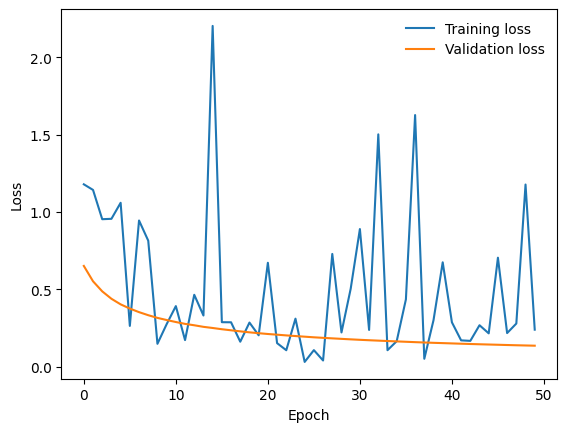

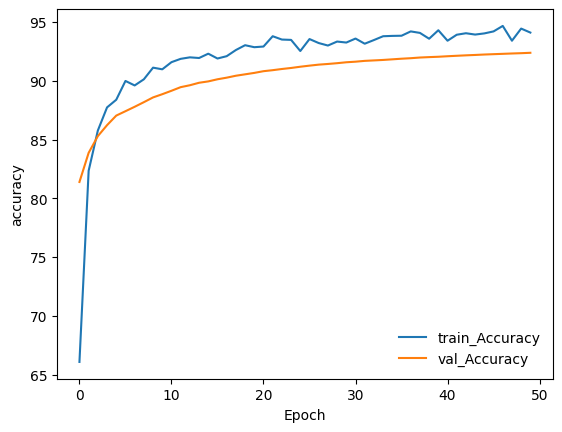

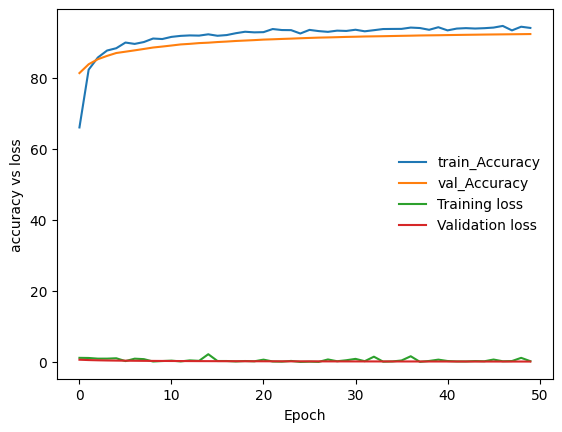

In [9]:
import matplotlib.pyplot as plt
best_vloss = 2

epoch_number=50
# calculate validation loss and accuracy
val_loss = 0.0
val_correct = 0
val_total = 0
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies=[]
for epoch in range(epoch_number):
    running_loss = 0.0
    correct = 0
    total = 0
    model.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
         # calculate training loss
        avg_trainLoss=running_loss / len(train_loader.dataset)
        avg_trainAccuracy= 100 * correct / total
    model.eval()
    #num_batches = 0
    with torch.no_grad():
        for i,data in enumerate(valid_loader):
            images, labels = data
            outputs = model(images)
            val_loss += criterion(outputs, labels).item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
        avg_valLoss = val_loss / (val_total +1)
        avg_Val_Accuracy = (100 * val_correct / val_total)
        train_losses.append(loss.item())
        val_losses.append(avg_valLoss)
        train_accuracies.append(avg_trainAccuracy)
        val_accuracies.append(avg_Val_Accuracy)
   # Log the running loss averaged per batch
    # for both training and validation
        global_step = epoch * len(train_loader) + i
        writer.add_scalars('loss', {'Training Loss': loss.item(),
                                    'Validation Loss': avg_valLoss}, global_step)
        writer.add_scalars('Accuracy', {'Training Accuracy': avg_trainAccuracy,
                                    'Validation Accuracy': avg_Val_Accuracy}, global_step)
        
        #Close tensorboard writer
        writer.close()
    print('Epoch %d: Training Loss: %.3f -- Training Accuracy: %.3f%%  -- Validation Loss: %.3f  -- Validation Accuracy: %.3f%%' %
          (epoch + 1, avg_trainLoss, avg_trainAccuracy, avg_valLoss, avg_Val_Accuracy))
    
    
    
    

    # Track best performance, and save the model's state
    if avg_valLoss < best_vloss:
        best_vloss = avg_valLoss
        model_path = os.path.join(Saved_model_path, filename + '.pth')
        torch.save(model.state_dict(), model_path)
    
    epoch_number += 1

plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
# Plot the training and validation accuracy
plt.plot(train_accuracies, label='train_Accuracy')
plt.plot(val_accuracies, label='val_Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(frameon=False)
plt.show()
plt.plot(train_accuracies, label='train_Accuracy')
plt.plot(val_accuracies, label='val_Accuracy')
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.ylabel('accuracy vs loss')
plt.xlabel('Epoch')
plt.legend(frameon=False)
plt.show()

Test Accuracy: 94.60
Confusion matrix:
[[93.5483871   0.80645161  0.2016129   3.62903226  1.81451613]
 [ 0.83333333 97.5         0.41666667  0.41666667  0.83333333]
 [ 1.54867257  0.88495575 87.61061947  3.53982301  6.4159292 ]
 [ 0.          0.          0.         99.5         0.5       ]
 [ 0.          0.          0.33112583  3.97350993 95.69536424]]


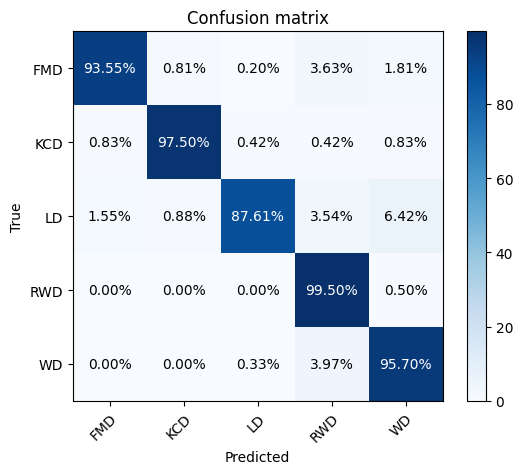

              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96       496
         1.0       0.98      0.97      0.98       480
         2.0       0.99      0.88      0.93       452
         3.0       0.89      0.99      0.94       400
         4.0       0.87      0.96      0.91       302

    accuracy                           0.95      2130
   macro avg       0.94      0.95      0.94      2130
weighted avg       0.95      0.95      0.95      2130



In [8]:

import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,precision_recall_fscore_support

model_path = os.path.join(Saved_model_path, filename + '.pth')
# Load saved model
model.load_state_dict(torch.load(model_path))

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, labels in TestLoader:
        data=data 
        labels =  labels
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}")

# Load saved model
model.load_state_dict(torch.load(model_path))

# Set model to evaluation mode
model.eval()

# Define empty arrays for storing true labels and predicted labels
true_labels = np.array([])
pred_labels = np.array([])

# Define empty arrays for storing loss and accuracy
loss_list = []
accuracy_list = []

# Evaluate model on test set
model.eval()
with torch.no_grad():
    for data, labels in TestLoader:
        data = data
        labels = labels

        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Get predictions and calculate accuracy
        _, preds = torch.max(outputs, 1)
        true_labels = np.append(true_labels, labels.cpu().numpy())
        pred_labels = np.append(pred_labels, preds.cpu().numpy())
        accuracy = accuracy_score(true_labels, pred_labels) * 100
        accuracy_list.append(accuracy)


# Create confusion matrix
conf_mat = confusion_matrix(true_labels, pred_labels)
# Normalize confusion matrix to percentages
conf_mat_pct = 100 * conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

# Print confusion matrix
print('Confusion matrix:')
print(conf_mat_pct)

# Plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(conf_mat_pct, cmap='Blues')

# Add color bar
cbar = ax.figure.colorbar(im, ax=ax)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(class_labels)))
ax.set_yticks(np.arange(len(class_labels)))
ax.set_xticklabels(class_labels)
ax.set_yticklabels(class_labels)

# Set axis labels
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Loop over data dimensions and create text annotations
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        ax.text(j, i, format(conf_mat_pct[i, j], '.2f') + '%',
                ha='center', va='center', color='white' if conf_mat[i, j] > conf_mat.max() / 2 else 'black')

# Set title
ax.set_title('Confusion matrix')

# Show plot
plt.show()
# classification report
print(classification_report(true_labels, pred_labels))

# accuracy score
acc = accuracy_score(true_labels, pred_labels)

# precision, recall, f1-score, support
precision, recall, f1score, support = precision_recall_fscore_support(true_labels, pred_labels)

In [ ]:

model_path = os.path.join(Saved_model_path, filename + '.pth')
# Load saved model
model.load_state_dict(torch.load(model_path))

model.eval()

# Load single test image and preprocess it
from PIL import Image
import torchvision.transforms as transforms

img_path = "E:/jupyter notebook/my_trying_fie/All_In_One/DatasetContainer/Processed_10000_FirstGA_other/test/Foot_mouth_disease/FMD11 (34).jpg"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0., 0., 0.],
                         std=[1./255, 1./255, 1./255])
])

img = Image.open(img_path)
img_tensor = transform(img)
img_tensor = img_tensor.unsqueeze(0) # add batch dimension

# Test model on single image
with torch.no_grad():
    outputs = model(img_tensor)
    _, predicted = torch.max(outputs.data, 1)

print('Predicted class: ', predicted.item())